# Batch UCB


In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

**Update 13/Nov/2020** Generate recommendation for round 2 (with partial replicates for round 0 and 1)

In [2]:
Path = '../../data/Results_Microplate_partialTrue_normTrue_roundRep_formatSeq_logTrue.csv'

known_df = pd.read_csv(Path)
known_df.head()

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,...,Round,Unnamed: 16,Rep7,Rep8,Rep9,RBS6,index,Pred Mean,Pred Std,Pred UCB
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,2.482263,2.555338,2.358414,3.102950,2.999178,2.316265,2.635735,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
1,1,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.592779,1.694296,1.798210,1.850738,2.381356,1.996343,1.885620,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
2,2,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.626302,0.774704,0.947196,0.418233,0.532036,0.733023,0.671916,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
3,3,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.696364,1.917735,1.568130,1.600853,1.803056,1.260720,1.641143,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
4,4,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.582321,2.118618,1.417531,2.014216,1.831391,2.186262,1.858390,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN


In [3]:
# known_df = known_df[known_df['Group'] != 'bps_noncore']
# known_df.reset_index(inplace=True, drop=True)
# known_df['RBS'] = known_df['RBS6']
# known_df

## Conclusion of pipeline

- Data pre-processing: run codes/data_generating.py
    - log transform 
    - z-score normalisation for each replicate (zero mean and unit variance)
- Kernel: codes/kernels_for_GPK.py
    - weighted degree kernel with shift
    - normalisation: centering; unit variance; normalisation over the whole (train + test) kernel
    - l = 6 (maximum substring length)
    - s = 1 (shift)
    - sigma0 = 1 (signal std)
- Regression: codes/regression.py
    - Gaussian Process Regression
    - train on samples (multi-label) from first round result, i.e. train shape:  (1055, 20)
    - predict on all design space (4 * 6) except known sequences, i.e. test shape:  (3961, 20)
    - alpha = 2
- Recommendation: codes/batch_ucb.py
    - batch UCB (GP-BUCB)
    - beta = 2
    - recommendation size = 90

In [4]:
rec_size = 90
l = 6
s = 1
beta = 2
alpha = 2
sigma_0 = 1
kernel_name = 'WD_Kernel_Shift'
embedding = 'label'
kernel_norm_flag = True

## Top n recommendations

return seuqneces with top n ucb score. 

In [5]:
top_n = Top_n_ucb(known_df, kernel_name=kernel_name, l=l, s=s, sigma_0=sigma_0,
                 embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta, kernel_norm_flag=kernel_norm_flag)

In [19]:
unknown_df = top_n.generate_design_space()
# unknown_df.to_csv('unknown_df.csv')
unknown_df.shape

(3873, 2)

In [6]:
top_n_rec_df = top_n.run_experiment()

X train shape:  (1328, 20)
X test shape:  (3873, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg


(array([ 11.,  23., 104., 232., 419., 778., 971., 883., 394.,  58.]),
 array([0.40605122, 0.44224713, 0.47844304, 0.51463896, 0.55083487,
        0.58703078, 0.62322669, 0.6594226 , 0.69561851, 0.73181442,
        0.76801033]),
 <a list of 10 Patch objects>)

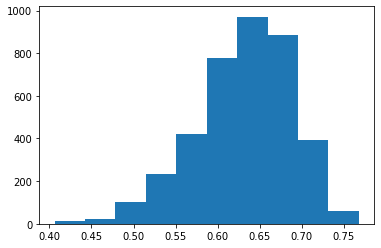

In [7]:
plt.hist(top_n.df_design['pred std'])

(array([ 1.,  0.,  1.,  1.,  4.,  8., 22., 19., 18., 16.]),
 array([0.42835332, 0.46231902, 0.49628472, 0.53025042, 0.56421612,
        0.59818182, 0.63214752, 0.66611322, 0.70007892, 0.73404463,
        0.76801033]),
 <a list of 10 Patch objects>)

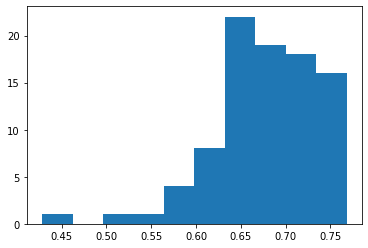

In [8]:
plt.hist(top_n_rec_df['pred std'])

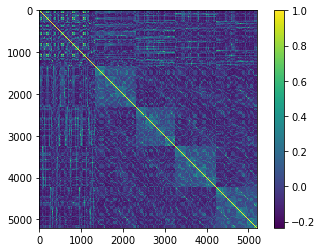

In [9]:
kernel_matrix = top_n.gpr.wd_kernel_instance.kernel_all_normalised
plt.imshow(kernel_matrix)
plt.colorbar()

## GP-BUCB

Desautels et al. 2014 Algorithm 2
http://jmlr.org/papers/volume15/desautels14a/desautels14a.pdf

In [10]:
gpbucb = GP_BUCB(known_df, kernel_name=kernel_name, l=l, s=s,sigma_0=sigma_0,
                 embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta, kernel_norm_flag=kernel_norm_flag)

In [11]:
gpbucb_rec_df = gpbucb.run_experiment()

X train shape:  (1328, 20)
X test shape:  (3873, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (267, 28)
X train shape:  (1329, 20)
X test shape:  (3872, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (268, 28)
X train shape:  (1330, 20)
X test shape:  (3871, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (269, 28)
X train shape:  (1331, 20)
X test shape:  (3870, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (270, 28)
X train shape:  (1332, 20)
X test shape:  (3869, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (271, 28)
X train shape:  (1333, 20)
X test shape:  (3868, 20)
create kernel instance
init kernel
finish creating kernel instance


finish reg
train size  (313, 28)
X train shape:  (1375, 20)
X test shape:  (3826, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (314, 28)
X train shape:  (1376, 20)
X test shape:  (3825, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (315, 28)
X train shape:  (1377, 20)
X test shape:  (3824, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (316, 28)
X train shape:  (1378, 20)
X test shape:  (3823, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (317, 28)
X train shape:  (1379, 20)
X test shape:  (3822, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (318, 28)
X train shape:  (1380, 20)
X test shape:  (3821, 20)
create kernel instance
init kernel

## Recommendation results

In [12]:
gpbucb_rec_df

,level_0,AVERAGE,Group,Name,PERC,Plate,Pred Mean,Pred Std,Pred UCB,RBS,...,STD,Unnamed: 0,Unnamed: 16,Usable,index,train_test,label,pred mean,pred std,ucb
0,1363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.864297,0.701432,2.267161
1,1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACAGGAGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.981678,0.625964,2.233606
2,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACAGGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.761413,0.720742,2.202897
3,1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.911292,0.614384,2.140059
4,1367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCGTTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.756257,0.666317,2.088890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCTAATATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.630919,0.543627,1.718173
86,1298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGCGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.625590,0.545698,1.716985
87,3029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGATACAGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.428777,0.642032,1.712841
88,1383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCCTTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.506572,0.601248,1.709068


In [13]:
top_n_rec_df

,level_0,AVERAGE,Group,Name,PERC,Plate,Pred Mean,Pred Std,Pred UCB,RBS,...,STD,Unnamed: 0,Unnamed: 16,Usable,index,train_test,label,pred mean,pred std,ucb
1629,1363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.864297,0.701432,2.267161
2274,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACAGGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.761413,0.743151,2.247715
2264,1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACAGGAGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.981678,0.626026,2.233730
1566,1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.911292,0.645770,2.202832
2031,1765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGTGGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.659087,0.746430,2.151947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,1591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGCCGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.476111,0.683621,1.843354
3122,2856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACTTGAGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.544324,0.649403,1.843130
844,578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAACGGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.410865,0.713989,1.838844
1626,1360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCGCATATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.449646,0.694568,1.838781


In [14]:
top_n_rec_df.index

Int64Index([1629, 2274, 2264, 1566, 2031, 2336, 2278, 2150, 1633, 1618, 2400,
            2326, 1620, 1400, 1688, 2021, 1608, 3317, 1570, 3254, 3980, 3244,
            1614, 1624,  596, 2330, 2886, 3497, 1635, 1390, 2340, 2141,  417,
            2265, 2035, 2291, 2252, 1639, 2284, 3970, 3307, 1657, 2390, 2520,
            2864, 1678,  657, 1558, 2384, 2870, 3258, 1394,  407, 1404, 3132,
            2258, 2294, 2874, 2378, 1646, 3549, 3311, 2266, 3984, 3321, 1615,
            2280, 2876, 1627, 2154, 3073, 1637,  411, 2744,  600, 2271, 2581,
            2272, 3378,  967, 1649, 2388, 3501, 2394, 2041, 1857, 3122,  844,
            1626, 1682],
           dtype='int64')

### Similarity between recommendations

characterized by the same kernel used for prediction.

init kernel
init kernel
init kernel


Text(0.5, 1.0, 'GP_BUCB hist')

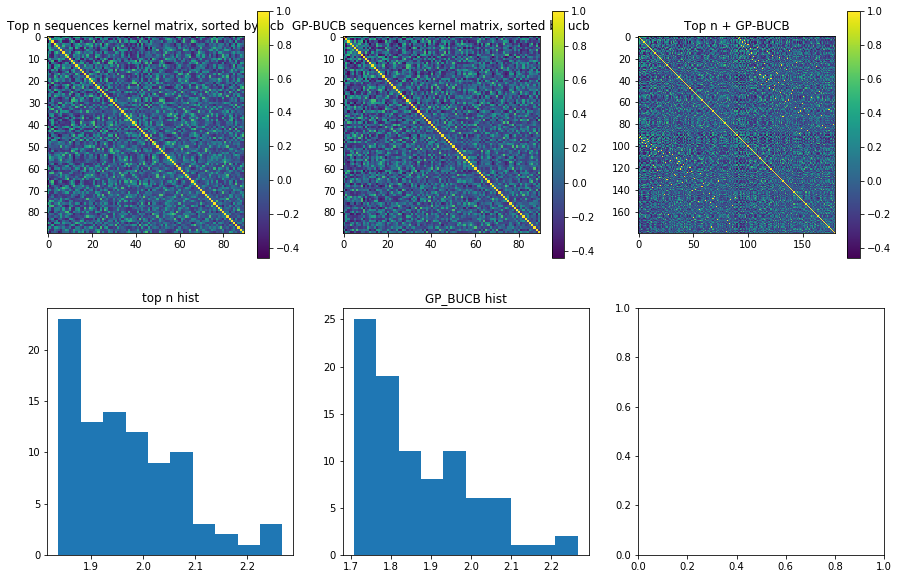

In [15]:
num_rows = 2
num_cols = 3

wd_kernel = WD_Shift_Kernel
fig,a = plt.subplots(num_rows, num_cols, figsize = (15,10))

wd_kernel.INIT_FLAG = False
im = a[0][0].imshow(wd_kernel(l=6, features = np.asarray(top_n_rec_df['RBS'])).kernel_all_normalised, cmap = 'viridis')
fig.colorbar(im, ax =a[0][0])
a[0][0].set_title('Top n sequences kernel matrix, sorted by ucb')

wd_kernel.INIT_FLAG = False
im = a[0][1].imshow(wd_kernel(l=6, features = np.asarray(gpbucb_rec_df['RBS'])).kernel_all_normalised, cmap = 'viridis')
fig.colorbar(im, ax =a[0][1])
a[0][1].set_title('GP-BUCB sequences kernel matrix, sorted by ucb')

wd_kernel.INIT_FLAG = False
all_features = np.concatenate((np.asarray(top_n_rec_df['RBS']), np.asarray(gpbucb_rec_df['RBS'])), axis = 0)
im = a[0][2].imshow(wd_kernel(l=6, features = all_features).kernel_all_normalised, cmap = 'viridis')
fig.colorbar(im, ax =a[0][2])
a[0][2].set_title('Top n + GP-BUCB')

im = a[1][0].hist(top_n_rec_df['ucb'])
a[1][0].set_title('top n hist')

im = a[1][1].hist(gpbucb_rec_df['ucb'])
a[1][1].set_title('GP_BUCB hist')

# im = a[1][2].hist(gpbucb_rec_df['ucb'])
# a[1][2].set_title('GP_BUCB hist')

In [16]:
common_rec = set(top_n_rec_df['RBS']).intersection(set(gpbucb_rec_df['RBS']))
print('Number of intersection of recommendations: ', len(common_rec))

Number of intersection of recommendations:  70


In [17]:
para_name = '_alpha' + str(alpha) + '_beta' + str(beta) + 'kernelNorm' + str(kernel_norm_flag)

with pd.ExcelWriter('batch_ucb.xlsx', engine="openpyxl", mode='a') as writer:
    top_n_rec_df.to_excel(writer, sheet_name = 'top_n_core_' + para_name)
    gpbucb_rec_df.to_excel(writer, sheet_name = 'gpbucb_core_' + para_name)

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/openpyxl/workbook/child.py:102: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
